In [2]:
import pyfair

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [3]:
import pyfair

from pyfair.report.base_report import FairBaseReport

In [4]:
model1 = pyfair.FairModel(name="HA1", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=20, mode=100, high=900)
model1.input_data('Probable Loss Magnitude', low=3_000_000, mode=3_500_000, high=5_000_000)
model1.calculate_all()

model2 = pyfair.FairModel(name="HA2", n_simulations=10_000)
model2.input_data('Loss Event Frequency', low=.5, mode=.7, high=.9)
model2.input_data('Probable Loss Magnitude', low=2_000_000_000, mode=3_000_000_000, high=5_000_000_000)
model2.calculate_all()

model3 = pyfair.FairModel(name="HA3", n_simulations=10_000)
model3.input_data('Loss Event Frequency', low=10, mode=15, high=16)
model3.input_data('Probable Loss Magnitude', low=500_000_000, mode=500_900_000, high=600_000_000)
model3.calculate_all()

#fr = FairReport(model1)
#fr.to_html('C:/Users/theon/Desktop/report.html')
results = model1.export_results()
node_statuses = model1.get_node_statuses()

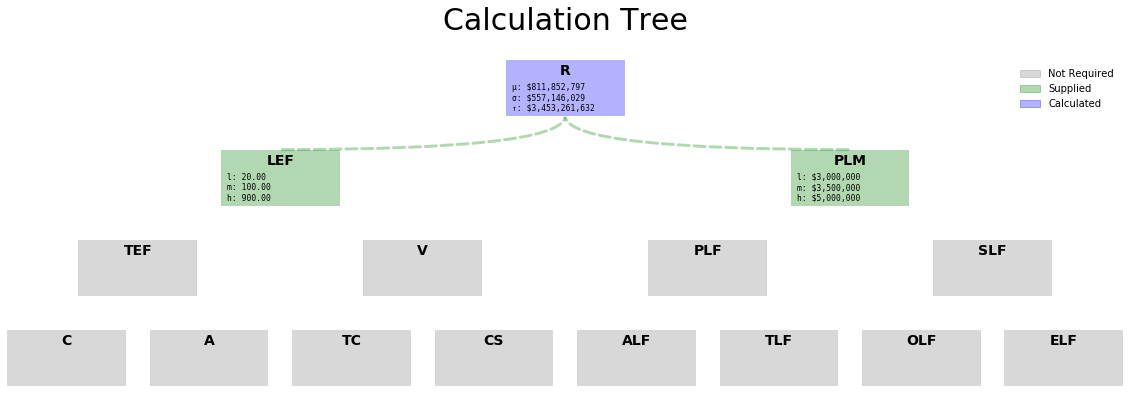

In [6]:
class FairSimpleReport(FairBaseReport):
    
    def __init__(self, model):
        super().__init__()
        self._model = model
        self._css = self._template_paths['css'].read_text()
        self._template = self._template_paths['simple'].read_text()
        
    def _construct_output(self):
        '''Function called by FairBaseReport.to_html()'''
        # Alias
        t = self._template
        # Add css
        t = t.replace('{STYLE}', self._css)
        # Add Metadata
        t = t.replace('{METADATA}', self._get_metadata_table())
        # Get logo tag
        b64 = self.base64ify(self._logo_location)
        t = t.replace('{PYTHON_LOGO}', b64)
        # Get tree tag
        tree_tag = self._get_tree(self._model)
        t = t.replace('{TREE}', tree_tag)
        # Replace text
        data = self._model.export_results()
        risk = data['Risk']
        # Shoud this be done within model?
        overview_df = pd.DataFrame(
            columns=['Risk'],
            index=['Mean', 'Stdev', 'Maximum', 'Minimum'],
            data=[risk.mean(), risk.std(), risk.max(), risk.min()]
        )
        overview_df = overview_df.applymap(lambda x: self._format_strings['Risk'].format(x))
        overview_df.loc['Simulations'] = '{0:,.0f}'.format(len(risk))
        overview_df.loc['Identifier'] = self._model.get_uuid()
        overview_html = overview_df.to_html(border=0, header=True, justify='left', classes='fair_table')
        t = t.replace('{OVERVIEW_DATAFRAME}', overview_html)
        return t
        
fsr = FairSimpleReport(model1)
fsr.to_html('output.html')

# Components

<section header and metadata>

<section overview>

* Summary General
    * Summary Table (mean, stdev, low, high, n)
    * hist
    * Exceedence curves
* Summary Comparison
    * Summary Table (mean, stdev, low, high, n)
    * Summary Table 2
    * Combined Hist
    * Exceedence curves
    
<section parameters>

* Model Detail
    * Parameter table with distributions
* Metamodel Detail
    * Risk table with stacked area
    
<section> and source code
* JSON

# Reports
* Compare
* Single
* Metamodel Drilldown

NameError: name 'tf' is not defined

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(<Figure size 288x36 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26e5445c080>)

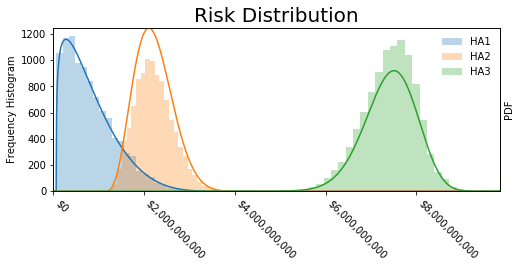

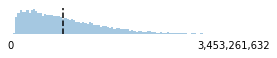

In [19]:
from pyfair.report.distribution import FairDistributionCurve

fdc = FairDistributionCurve([model1, model2, model3])
#fig, ax = fdc.generate_image()

fig, ax = fdc.generate_image()
fdc.generate_icon('HA1', 'Risk')

In [24]:
import io

bio = io.BytesIO()
fig.savefig(bio)

In [26]:
# Notes
# ComponentSubReport
# ComparisonSubReport
# SingleReport
# MetaReport
# Report
#

bio.seek(0)
bio.read()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02@\x00\x00\x00\xd8\x08\x06\x00\x00\x00\x030\\1\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x009tEXtSoftware\x00matplotlib version 3.0.2, http://matplotlib.org/8\x80;\xad\x00\x00 \x00IDATx\x9c\xec\xddyxT\xd5\xf9\xc0\xf1\xef,\xd97\x12\xc8\xbe\x12\x02\x845\x01\xc2&H\xd8A,A(J\x15\x11\x14\x01\xb5\xb8ki\x7f\xb6U\xac\x16\xb4Z\x95b\xab(\xb2\xb8\xa0\x05\xaa\x80\x02B\xd8\x17\x91\x84\x10\xb6@\x08\x90=!{H\xc8\x9e\x99\xfb\xfbc\xccHH\x80,\x93{g\x92\xf3y\x9e<a\xee\xdc9\xe7\xcd\x88\x99\x97s\xdes\x8eJ\x92$\tA\x10\x04A\x10\x84\x0eD\xadt\x00\x82 \x08\x82 \x08r\x13\t\x90 \x08\x82 \x08\x1d\x8eH\x80\x04A\x10\x04A\xe8pD\x02$\x08\x82 \x08B\x87#\x12 A0#\xfb\xf7\xefG\xa5R\xf1\xdak\xaf\xb5\xe8\xf5k\xd7\xaeE\xa5R\xb1v\xedZ\x93\xc6\xd5\\*\x95\x8a\xd1\xa3G+\xd6\x7fPP\x10AAA\xf5\xae\x89\xf7F\x10\x84\x1b\x89\x04H\x10\xda\x88J\xa5\xaa\xf7\xa5\xd1hpssc\xf4\xe8\xd1\xac]\xbb\x16s^\x80Y\x97\x88\xdd\

In [ ]:
fpc = FairExceedenceCurves([model1, model2, model3])
fig1, ax1 = fpc.generate_image()

In [ ]:
results.T
rep = FairReport(model1)

In [ ]:
import matplotlib

matplotlib.style.use('fivethirtyeight')

In [ ]:
dir(model1)

hasattr(object, '__iter__')

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as stats

from matplotlib.ticker import StrMethodFormatter

from pyfair.model.model import FairModel
from pyfair.model.meta_model import FairMetaModel
from pyfair.utility.fair_exception import FairException


class FairExceedenceCurves(object):
    '''Plots one or more exceedence curves'''
    
    def __init__(self, model_or_iterable):
        # If it's just a model, make it a list.
        self._input = self._input_check(model_or_iterable)

    def _input_check(self, value):
        # If it's a model or metamodel, plug it in a dict.
        rv = {}
        if value.__class__.__name__ in ['FairModel', 'FairMetaModel']:
            rv[value.get_name()] = value
            return rv
        # Check for iterable.
        if not hasattr(value, '__iter__'):
            raise FairException('Input is not a FairModel, FairMetaModel, or an iterable.')
        # Iterate and process remainder.
        for proported_model in value:
            if proported_model.__class__.__name__ in ['FairModel', 'FairMetaModel']:
                rv[proported_model.get_name()] = proported_model
            else:
                raise FairException('Iterable member is not a FairModel or FairMetaModel')
        return rv
    
    def generate_image(self):
        '''Main function for generating plots'''
        # Setup plots
        fig, axes = plt.subplots(2,1, figsize=(6, 8))
        plt.subplots_adjust(hspace=.5)
        ax1, ax2 = axes
        # For each model, calculate and plot.
        for name, model in self._input.items():
            data = model.export_results()
            # Get Risk Data
            risk = data['Risk']
            risk_max = risk.max()
            # Create feature space
            space = pd.Series(np.linspace(0, risk_max, 100))
            # Get X and Y for each calculation
            prob_xy = self._get_prob_data(space, risk)
            loss_xy = self._get_loss_data(space, risk)
            # Generate curves with x and y
            self._generate_prob_curve(name, ax1, *prob_xy)
            self._generate_loss_curve(name, ax2, *loss_xy)
        return (fig, (ax1, ax2))
    
    def _get_prob_data(self, space, risk):
        '''Get the percentle score for each risk value'''
        quantiles = space.map(lambda x: stats.percentileofscore(risk, x))
        return (quantiles, space)
    
    def _get_loss_data(self, space, risk):
        '''Get percentage of values under loss value for each value'''
        loss_ex = space.map(lambda value: (value < risk).mean())
        return (space, loss_ex * 100)    
        
    def _generate_prob_curve(self, name, ax, quantiles, space):
        '''For each percentile, what is the expected loss?'''
        # Plot
        ax.plot(quantiles, space)
        # Style
        ax.axes.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
        ax.axes.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))
        ax.axes.set_title('Exceedence Probability Curve', fontsize=20)
        ax.legend(name, frameon=False)
    
    def _generate_loss_curve(self, name, ax, space, loss_expectancy):
        '''For each dollar amount, what was the probability that loss was exceeded?'''
        # Plot
        ax.plot(space, loss_expectancy)
        # Style
        ax.axes.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}%'))
        ax.axes.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
        ax.axes.xaxis.set_tick_params(rotation=-45)
        for tick in ax.axes.xaxis.get_major_ticks():
            tick.label.set_horizontalalignment('left')
        ax.axes.set_title('Loss Exceedence Curve', fontsize=20)
        ax.legend(name, frameon=False)




fpc = FairExceedenceCurves([model1, model2])
fig1, ax1 = fpc.generate_image()

In [ ]:
model1.__class__.__name__

In [ ]:

import scipy.stats as stats

import matplotlib.pyplot as plt

r = model1.export_results()
p = model1.export_params()

risk = r['Risk']
risk_min = risk.min()
risk_max = risk.max()

# Loss Exceedence Curbe
space = np.linspace(0, risk_max, 100)
series = pd.Series(space)
quantiles = series.map(lambda x: stats.percentileofscore(risk, x))
ax = plt.plot(quantiles, series)[0]

xax = ax.axes.xaxis
yax = ax.axes.yaxis

yax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
xax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))

ax.axes.set_title('Exceedence Probability Curve')

In [ ]:
# For each point dollar amount, the probability it was exceeded
fbp = FairBetaPert(low=20_000_000, high=100_000_000, mode=23_000_000)
rand = fbp.random_variates(100_000)

space = np.linspace(0, rand.max(), 100)
series = pd.Series(space)
loss_ex = series.map(lambda value: (value < rand).mean())
ax = plt.plot(space, loss_ex * 100)[0]

xax = ax.axes.xaxis
yax = ax.axes.yaxis

xax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
yax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))

xax.set_tick_params(rotation=-45)
for tick in xax.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    
ax.axes.set_title('Loss Exceedence Curve')

In [ ]:
model1 = pyfair.FairModel(name="HA", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model1.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model1.calculate_all()

model2 = pyfair.FairModel(name="NOT HA", n_simulations=10_000)
model2.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model2.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model2.calculate_all()


meta1 = pyfair.FairMetaModel('Metamodel', [model1, model2])
out_json = pyfair.FairMetaModel('Metamodel2', [model1, meta1])

In [ ]:
str(type(meta1))

In [ ]:
'''
FairModel
    Just one
FairAddititveMetaModel
    Add all the risks together and display with components
FairComparativeMetaModel
    Put risks side by side
    
Mu, Sigma for Risk

Model Params

Source
'''

In [ ]:
metadata = pd.Series(
    {
        'Author': os.environ['USERNAME'],
        'Generated': str(pd.datetime.now()).partition('.')[0],
        'PyFair Version': pyfair.VERSION
    }
).to_frame()

metadata

In [ ]:
#### Left third, provided data. RIght 2/3rds, tree
model2 = pyfair.read_json(results)
params = model2.export_params()
data = model2.export_results()
del params['Creation Datetime']
df = pd.DataFrame.from_dict(params)
df = df.reindex(['low', 'mode', 'high', 'p'])
df.index = df.index.str.title()
df

In [ ]:
derived = df.agg([np.mean, np.std, np.min, np.max])
derived.index = ['μ', 'σ', 'Minimum', 'Maximum']

final_data = pd.concat([derived, df], axis=0)
final_data = final_data.dropna()

# If Column as data greater than 1,
condition = final_data.max() > 1

# Get True Clumns
true_col = condition.loc[condition].index.values

#Get False COlumns
false_col = condition.loc[~condition].index.values

# If false, it's between 0 and 1. 3 decimals
final_data[false_col] = final_data[false_col]
final_data[false_col] = final_data[false_col].applymap(lambda x: '{0:.3f}'.format(x))

# If true, get the max digits and round
final_data[true_col] = final_data[true_col].astype(int)
final_data[true_col] = final_data[true_col].applymap(lambda x: '{0:,}'.format(x))

for column in ['Probable Loss Magnitude', 'Risk']:
    if column in final_data.columns:
        final_data[column] = '$' + final_data[column]

final_data.T

In [ ]:
model3 = pyfair.read_json(results)
df3 = model3.export_results()
risk = df3['Risk']
risk_d = risk.agg([np.mean, np.std, np.min, np.max]).astype(int)
risk_d.index = ['μ', 'σ', 'Minimum', 'Maximum']

pd.DataFrame(risk_d).T.applymap(lambda x: '${0:,}'.format(x))

In [ ]:
# Draw curves?
model3.__class__

SINGLE
    header
    meta
    left third, risk top then params. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code
    
COMPARISON
    header
    meta
    left third, risk top then params for each. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code

ADDITIVE
    header
    meta
    for each:
        left third, risk top then params. right 2/3, tree diagram
        left have loss excedence, right half exceedence probability
    for all:
        loss exceedence and exceedence probability and 
        risk
    code

In [ ]:
class FairBasic()

In [ ]:
uuid.uuid1()

In [ ]:
import os
import subprocess
import tempfile

td = tempfile.mkdtemp()
tf = tempfile.NamedTemporaryFile(dir=td, mode='w+')
os.chdir(td)

tf.write('LATEX!')

os.listdir(td)

p = subprocess.run(['dir', str(td)])

In [ ]:
model

In [ ]:
td